In [43]:
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import os

from tools import PatchForager

In [44]:
# Example usage
type_patches = 2
num_patches = 400

#Three alternative ways to generate a list of patches
patch_list = list(range(type_patches)) #equal distribution of patches
# patch_list = [random.randint(0, type_patches-1) for _ in range(num_patches)] #randomly generated list of patched
# patch_list = data # import data from session {To Be Implemented..}

# Initial probabilities of reward in each patch
travel_time = 3
reward_value = [5, 5]
a = [0.9, 0.6]
b = [2.76, 2.76]
c = [0.1278, 0.1278]
d = [0, 0]

forager = PatchForager(travel_time, reward_value, a, b, c, d, prob=False)
mvt_optimal = forager.calculate_optimal_stops(patch_list)

print(f"Optimal stops: {mvt_optimal['optimal_stops'][0]}, {mvt_optimal['optimal_stops'][1]}")
print(f"Max reward rate: {mvt_optimal['max_reward_rate']}")

Optimal stops: 7, 4
Max reward rate: 1.8853650128723254


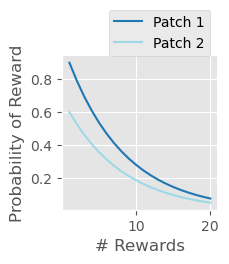

In [45]:
forager.make_pr_plot(patch_list, mvt_optimal['optimal_stops'])

In [46]:
# Create a directory for the simulation results
import h5py
os.makedirs('data', exist_ok=True)

type_patches = 2
num_patches = 200
patch_list = [random.randint(0, type_patches-1) for _ in range(num_patches)] #randomly generated list of patched

forager = PatchForager(travel_time, reward_value, a, b, c, d, prob=True)

# Define the strategies and their parameters
strategy_struct = {
    # 'rewards': {'strategy': 'rewards', 'params': {'target_rewards': [1,1]}}, #this seems to run forever sometimes, maybe never leaves?
    'stops': {'strategy': 'stops', 'params': {'target_stops': [12,8]}},
    'rate': {'strategy': 'rate', 'params': {'target_reward_rate': mvt_optimal['max_reward_rate']+1}},#mvt_optimal['max_reward_rate']}},2.55
    'failures': {'strategy': 'failures', 'params': {'max_failures': 2}},
    'consec_failures': {'strategy': 'consec_failures', 'params': {'consec_failures': 2}}
}

# Create an HDF5 file
with h5py.File('data/data.h5', 'w') as hf:
    for i in range(20):
        # Create a group for this simulation
        sim_group = hf.create_group(f'simulation_{i}')
        
        # Run the simulation for each strategy
        for strategy_name, strategy_info in strategy_struct.items():
            data, _ = forager.run_simulation(strategy_info['strategy'], patch_list, **strategy_info['params'])
            
            # Save results
            dataset = sim_group.create_dataset(strategy_name, data=data.to_numpy())
            # Save column names as attributes
            dataset.attrs['columns'] = data.columns.tolist()

In [47]:
print(mvt_optimal['max_reward_rate'],mvt_optimal['optimal_stops'])

1.8853650128723254 (7, 4)


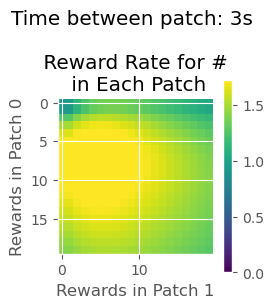

In [48]:
plt.figure(figsize=(2.5, 2.5))
ax = plt.subplot(111)
plt.imshow(mvt_optimal['reward_rate_grid'], vmin=0, vmax=1.7275)
plt.xlabel('Rewards in Patch 1')
plt.ylabel('Rewards in Patch 0')
plt.title('Time between patch: '+str(travel_time)+'s \n  \n Reward Rate for # \n in Each Patch')
ax.spines[['right', 'top']].set_visible(False)
cbar = plt.colorbar()


plt.savefig(f'figs/reward_rate_grid'+str(travel_time)+'.png', bbox_inches='tight', dpi=300)

In [49]:
# Function to read data from HDF5 file
def read_h5_data(file_path, simulation_number, strategy):
    with h5py.File(file_path, 'r') as hf:
        dataset = hf[f'simulation_{simulation_number}/{strategy}']
        return pd.DataFrame(dataset[:], columns=dataset.attrs['columns'])

# Set up the plotting style
plt.style.use('ggplot')

# File path
h5_file_path = 'data/data.h5'

# Get a list of distinct colors from matplotlib colormap
colors = plt.get_cmap('tab10')  # You can change 'tab10' to other colormaps if needed

# Create the color_set dictionary
color_set = {strategy: colors(i) for i, strategy in enumerate(strategy_struct.keys())}

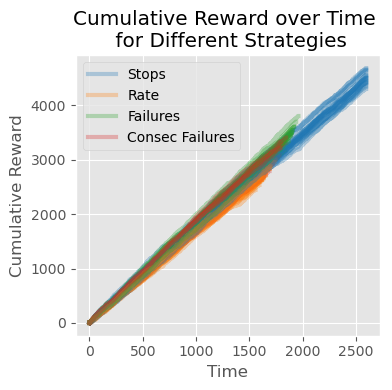

In [50]:
plt.figure(figsize=(4, 4))
for sim_num in range(20):  # Assuming 20 simulations

    for strategy in strategy_struct.keys():
        # Read data for this simulation and strategy
        data = read_h5_data(h5_file_path, sim_num, strategy)
        
        # Plot cumulative reward over time
        plt.plot(data['time'], data['reward'].cumsum(), label=strategy.replace('_', ' ').title(),alpha = .3,
                 lw = 3,color = color_set[strategy])

    plt.xlabel('Time')
    plt.ylabel('Cumulative Reward')
    plt.title(f'Cumulative Reward over Time \n for Different Strategies')
    
    if sim_num==0:
        plt.legend()
        
    plt.grid(True)
    plt.tight_layout()
    
    # Save the plot
plt.savefig(f'figs/cumulative_reward_all.png', bbox_inches='tight', dpi=300)
# plt.close()  # Close the figure to free up memory

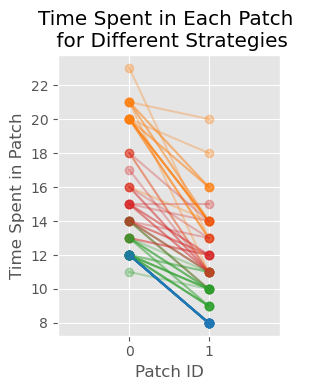

In [51]:
# Number of simulations
num_simulations = 20

# Plot: Time Spent in Each Patch
plt.figure(figsize=(3, 4))

for sim_num in range(num_simulations):
    for strategy in strategy_struct.keys():
        # Read data for this simulation and strategy
        data = read_h5_data(h5_file_path, sim_num, strategy)
        
        # Calculate time spent in each patch
        patch_times = data[data['patch_id'] != -1].groupby('patch_id')['time_in_patch'].max()
        
        # Plot time spent in each patch
        plt.plot(patch_times.index, patch_times.values, label=strategy if sim_num == 0 else "", 
                 marker='o', alpha=0.3, color=color_set[strategy])

plt.xlabel('Patch ID')
plt.xlim([-.9,1.9])
plt.ylabel('Time Spent in Patch')
plt.title('Time Spent in Each Patch \n for Different Strategies')
if sim_num == 0:
    plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(f'figs/patch_stops.png', bbox_inches='tight', dpi=300)


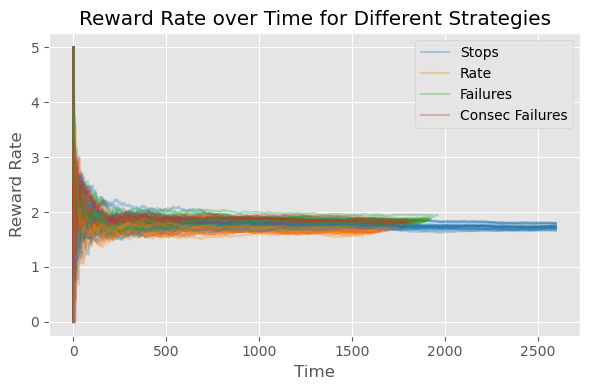

In [52]:
# Plot: Reward Rate over Time
plt.figure(figsize=(6, 4))
for sim_num in range(num_simulations):
    for strategy in strategy_struct.keys():
        # Read data for this simulation and strategy
        data = read_h5_data(h5_file_path, sim_num, strategy)
        
        # Calculate reward rate
        cumulative_reward = data['reward'].cumsum()
        reward_rate = cumulative_reward / data['time']
        
        # Plot reward rate over time
        plt.plot(data['time'], reward_rate, label=strategy.replace('_', ' ').title() if sim_num == 0 else "", 
                 alpha=0.3, color=color_set[strategy])
    if sim_num == 0:
        plt.legend()

plt.xlabel('Time')
plt.ylabel('Reward Rate')
plt.title('Reward Rate over Time for Different Strategies')

plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig('figs/reward_rate_all.png', bbox_inches='tight', dpi=300)

In [53]:
class SessionData:
    def __init__(self, simulated_data):
        self.df = simulated_data
        self.variables = ['time_in_patch', 'prob_reward', 'cumulative_patch_reward', 'failures_in_patch', 'consecutive_failures']
    
    def process_last_timesteps(self):
        # Group by patch visit and get the last row of each visit
        grouped = self.df[self.df['patch_id'] != -1].groupby((self.df['patch_id'] != self.df['patch_id'].shift()).cumsum())
        last_timesteps = grouped.last().reset_index(drop=True)
        return last_timesteps
    
    def plot_variables_by_patch(self):
        last_timesteps = self.process_last_timesteps()
        
        # Create a color map for patches
        unique_patches = last_timesteps['patch_id'].unique()
        color_map = plt.get_cmap('tab20')
        color_dict = {patch: color_map(i/len(unique_patches)) for i, patch in enumerate(unique_patches)}
        
        fig, axes = plt.subplots(1, len(self.variables), figsize=(12, 3), sharex=True)
        fig.suptitle('Variables at Patch Exit, Colored by Patch', fontsize=16)
        
        for i, var in enumerate(self.variables):
            ax = axes[i]
            for patch in unique_patches:
                patch_data = last_timesteps[last_timesteps['patch_id'] == patch]
                ax.scatter(patch_data.index, patch_data[var], 
                           c=[color_dict[patch]], label=f'Patch {patch}', s=10)
            
            ax.set_ylabel(var.replace('_', ' ').title())
            ax.grid(True, linestyle='--', alpha=0.3)
            ax.legend()
        
        axes[-1].set_xlabel('Patch Visit Number')
        
        plt.tight_layout()
        plt.show()

    def plot_overall_reward_rate(self):
        # Calculate cumulative sum of rewards
        cumulative_rewards = self.df['reward'].cumsum()
        
        # Use the 'time' column for total time
        total_time = self.df['time']
        
        # Calculate reward rate
        reward_rate = cumulative_rewards / total_time
        
        plt.figure(figsize=(3, 2))
        plt.plot(total_time, reward_rate)
        plt.xlabel('Time')
        plt.ylabel('Overall Reward Rate')
        # plt.title('Overall Reward Rate Throughout the Session')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()

stops


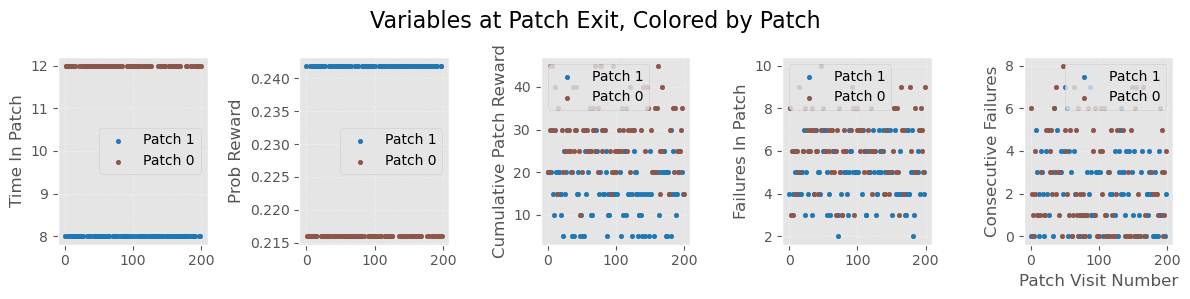

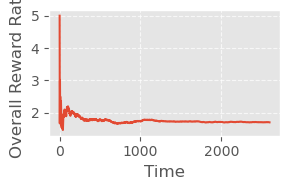

rate


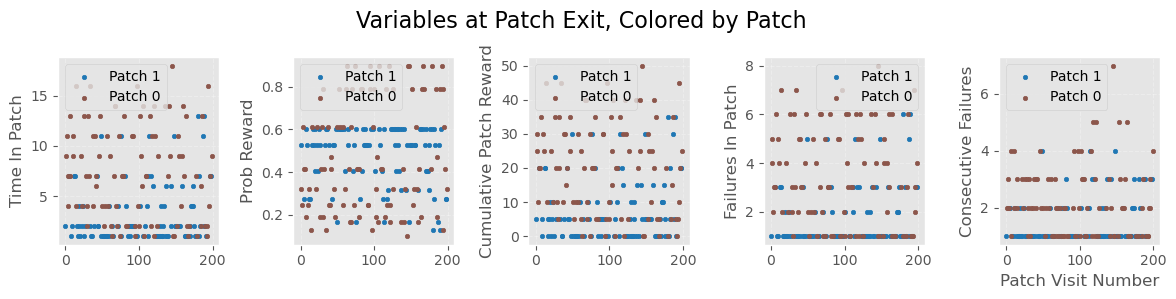

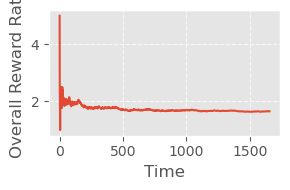

failures


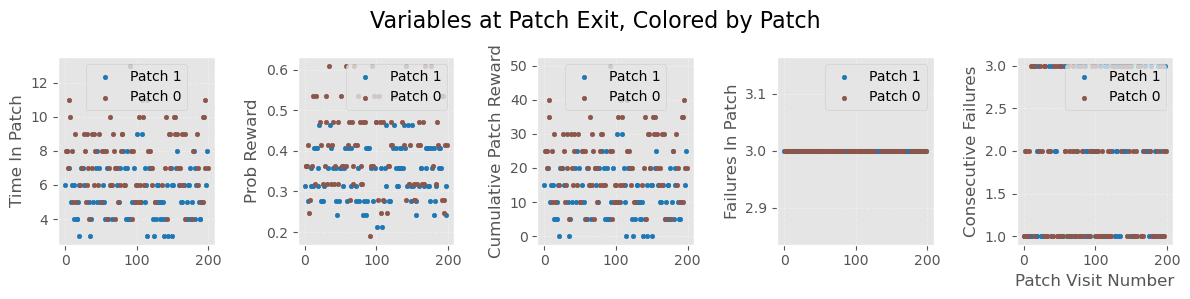

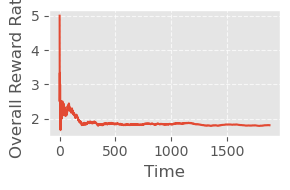

consec_failures


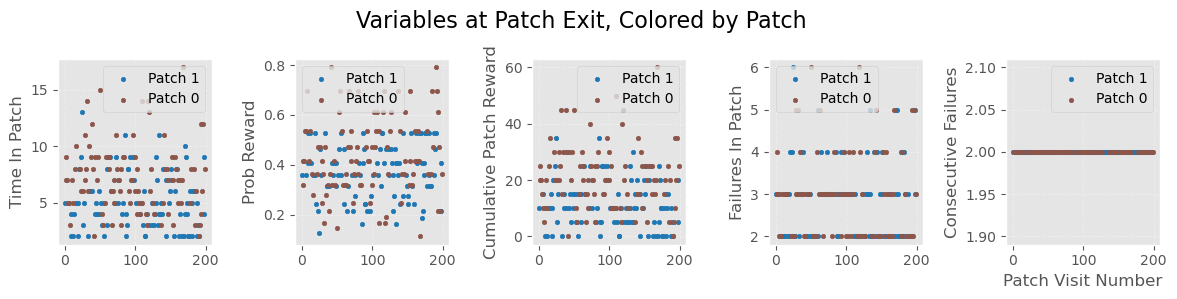

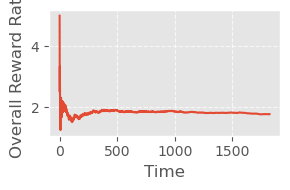

In [55]:
# Run the simulation for each strategy
results = {}
for strategy_name, strategy_info in strategy_struct.items():
    simulated_data, _ = forager.run_simulation(strategy_info['strategy'], patch_list, **strategy_info['params'])
    results[strategy_name] = data

    print(strategy_name)
    session = SessionData(simulated_data)
    session.plot_variables_by_patch()
    session.plot_overall_reward_rate()